# Numpy: manipulating arrays

Numpy's speedup is no joke.

**Normal Python:**

In [3]:
import random
data = []
for i in range(1000000):
    data.append(random.gauss(0, 1))

In [4]:
%%timeit
data2 = []
for x in data:
    data2.append(x**2)

10 loops, best of 3: 91.6 ms per loop


**Numpy:**

In [5]:
import numpy
data = numpy.random.normal(0, 1, 1000000)

In [6]:
%%timeit
data2 = data**2

1000 loops, best of 3: 1.57 ms per loop


**A Numpy array is everything normal Python data is not:**

   * Loop performed in native bytecode (compiled C)
   * Type-checking performed once before loop
   * Data are packed in contiguous bytes
   * Python's Global Interpreter Lock (GIL) is released during loop

**Bonus:**

   * Most methods also benefit from hardware vectorization

But you have to write your algorithms "sideways."

In [7]:
px = numpy.random.normal(0, 30, 100000)
py = numpy.random.normal(0, 30, 100000)
pz = numpy.random.normal(0, 300, 100000)

**Computing one event at a time ("normal"):**

In [8]:
%%timeit
p = numpy.empty(100000)
for i in range(len(p)):                                   # for each px[i], py[i], pz[i]
    p[i] = numpy.sqrt(px[i]**2 + py[i]**2 + pz[i]**2)     # compute p[i]

1 loop, best of 3: 250 ms per loop


**Computing one column at a time ("sideways"):**

In [9]:
%%timeit
p = numpy.sqrt(px**2 + py**2 + pz**2)       # compute all px**2, then all py**2, then all pz**2, then sum all, then sqrt all

The slowest run took 4.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 247 µs per loop


Normal math functions are *scalar* (e.g. binary operators like `+` or functions from `import math`). They perform one operation for each appearance in Python source code.

Numpy math functions are *vectorized.* Given equal-length arrays as input, they return the same length array as output, performing all loops in compiled C code, possibly doing 4 or 8 at a time in the CPU.

In [10]:
small_array = numpy.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
small_array**2

array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])

In [12]:
numpy.sqrt(small_array)

array([0.        , 1.        , 1.41421356, 1.73205081, 2.        ,
       2.23606798, 2.44948974, 2.64575131, 2.82842712, 3.        ])

In [13]:
# this won't work because math.sqrt wants a scalar number
import math
math.sqrt(small_array)

TypeError: only size-1 arrays can be converted to Python scalars

Numpy arrays are contiguous blocks of bytes in memory, just like C arrays.

In [14]:
small_array.view(numpy.float16)        # view (reinterpret_cast) the 64-bit integers as unsigned 8-bit integers

array([0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 6.0e-08, 0.0e+00, 0.0e+00,
       0.0e+00, 1.2e-07, 0.0e+00, 0.0e+00, 0.0e+00, 1.8e-07, 0.0e+00,
       0.0e+00, 0.0e+00, 2.4e-07, 0.0e+00, 0.0e+00, 0.0e+00, 3.0e-07,
       0.0e+00, 0.0e+00, 0.0e+00, 3.6e-07, 0.0e+00, 0.0e+00, 0.0e+00,
       4.2e-07, 0.0e+00, 0.0e+00, 0.0e+00, 4.8e-07, 0.0e+00, 0.0e+00,
       0.0e+00, 5.4e-07, 0.0e+00, 0.0e+00, 0.0e+00], dtype=float16)

They can be multidimensional.

In [15]:
twod = small_array.reshape(2, 1, 5, 1, 2)     # view as 2 arrays of 5 elements each (a constant-time reinterpretation)
twod

ValueError: cannot reshape array of size 10 into shape (2,1,5,1,2)

They can even be arrays of _structs!_

In [16]:
table = numpy.array([(0, -9, 0.0), (1, -7, 1.1), (2, -5, 2.2), (3, -3, 3.3), (4, -1, 4.4), (5, 1, 5.5), (6, 3, 6.6), (7, 5, 7.7), (8, 7, 8.8), (9, 9, 9.9)],
                    dtype=[("one", numpy.uint8), ("two", numpy.int64), ("three", numpy.double)])
table["three"]

array([0. , 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

Besides being a common, agreed-upon language for sharing arrays with C/C++ and Fortran code, Numpy has powerful index selection:

In [17]:
small_array[-1:1:-2]

array([9, 7, 5, 3])

In [18]:
twod[1, ::2]

NameError: name 'twod' is not defined

In [19]:
table["three"]

array([0. , 1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

In [20]:
table["three"][[False, False, True, False, False, True, False, True, False, True, True]]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 11

In [21]:
table["three"][[7, 5, 5, 3, 2, 7, -2]]

array([7.7, 5.5, 5.5, 3.3, 2.2, 7.7, 8.8])

In [22]:
table["two"][table["two"]]

array([-7, -3,  1,  5,  9, -7, -3,  1,  5,  9])

In [23]:
table["three"][numpy.tile([7, 2], 5)]

array([7.7, 2.2, 7.7, 2.2, 7.7, 2.2, 7.7, 2.2, 7.7, 2.2])

The same rules apply to *assigning* to arrays.

In [24]:
small_array[[False, False, False, False, False, True, False, True, False, True]] = 5000, 7000, 9000

In [25]:
small_array

array([   0,    1,    2,    3,    4, 5000,    6, 7000,    8, 9000])

Be careful changing things in place!

In [26]:
view = small_array[5:]
view

array([5000,    6, 7000,    8, 9000])

In [27]:
view[0] = 999

In [28]:
small_array

array([   0,    1,    2,    3,    4,  999,    6, 7000,    8, 9000])

In [29]:
view.base is small_array

True

In [30]:
small_array.base is None

True

**Exercise:**

Suppose you're given a zillion `(px, py, pz, E)` 4-vectors and you want `(E, px, py, pz)` 4-vectors. Do it *fast!*

In [31]:
ZILLION = 1000000
fourvectors = numpy.empty((ZILLION, 4))
fourvectors[:, 0] = numpy.random.normal(0, 1, ZILLION)
fourvectors[:, 1] = numpy.random.normal(0, 1, ZILLION)
fourvectors[:, 2] = numpy.random.normal(0, 10, ZILLION)
fourvectors[:, 3] = numpy.random.normal(0, 10, ZILLION)**2
fourvectors[0]

array([-1.58996933,  1.15037539,  4.17023877,  0.97731813])

In [32]:
%%timeit
reordered = numpy.empty((ZILLION, 4))
reordered[:, 0] = fourvectors[:, 3]
reordered[:, 1] = fourvectors[:, 0]
reordered[:, 2] = fourvectors[:, 1]
reordered[:, 3] = fourvectors[:, 2]

10 loops, best of 3: 24.7 ms per loop


# uproot: ROOT → Numpy

There are several ways to get ROOT data into Numpy arrays:

   * Pythonic iteration in PyROOT (super slow)
   * use ROOT's new `TTree::AsMatrix` (for flat tables)
   * through a custom C++ function
   * with `root_numpy` (compiles against a ROOT version; can segfault with version mismatch)
   * uproot* is a pure-Python, minimal dependency reimplementation of ROOT I/O

<i>(*disclosure: I'm the author)</i>

In [ ]:
!pip install uproot --force-reinstall

In [33]:
import uproot

In [34]:
events = uproot.open("http://scikit-hep.org/uproot/examples/HZZ.root")["events"]
events.keys()

['NJet',
 'Jet_Px',
 'Jet_Py',
 'Jet_Pz',
 'Jet_E',
 'Jet_btag',
 'Jet_ID',
 'NMuon',
 'Muon_Px',
 'Muon_Py',
 'Muon_Pz',
 'Muon_E',
 'Muon_Charge',
 'Muon_Iso',
 'NElectron',
 'Electron_Px',
 'Electron_Py',
 'Electron_Pz',
 'Electron_E',
 'Electron_Charge',
 'Electron_Iso',
 'NPhoton',
 'Photon_Px',
 'Photon_Py',
 'Photon_Pz',
 'Photon_E',
 'Photon_Iso',
 'MET_px',
 'MET_py',
 'MChadronicBottom_px',
 'MChadronicBottom_py',
 'MChadronicBottom_pz',
 'MCleptonicBottom_px',
 'MCleptonicBottom_py',
 'MCleptonicBottom_pz',
 'MChadronicWDecayQuark_px',
 'MChadronicWDecayQuark_py',
 'MChadronicWDecayQuark_pz',
 'MChadronicWDecayQuarkBar_px',
 'MChadronicWDecayQuarkBar_py',
 'MChadronicWDecayQuarkBar_pz',
 'MClepton_px',
 'MClepton_py',
 'MClepton_pz',
 'MCleptonPDGid',
 'MCneutrino_px',
 'MCneutrino_py',
 'MCneutrino_pz',
 'NPrimaryVertices',
 'triggerIsoMu24',
 'EventWeight']

One-per-event ROOT branches become Numpy arrays:

In [35]:
events.array("MET_px")

array([  5.912771,  24.765203, -25.785088, ...,  18.101646,  79.87519 ,
        19.713749], dtype=float32)

Multi-per-event ROOT branches become so-called "jagged arrays":

In [36]:
events.array("Jet_Px")

jaggedarray([[],
             [-38.874714],
             [],
             ...,
             [-3.7148185],
             [-36.361286 -15.256871],
             []])

A jagged array represents a list (events) of lists (particles).

In [37]:
px_events, py_events, pz_events = events.arrays(["Jet_Px", "Jet_Py", "Jet_Pz"], outputtype=tuple)

In [38]:
%%timeit
p = numpy.empty(2773)
j = 0
for i in range(events.numentries):
    for px, py, pz in zip(px_events[i], py_events[i], pz_events[i]):
        p[j] = math.sqrt(px**2 + py**2 + pz**2)
        j += 1

10 loops, best of 3: 35.5 ms per loop


But it consists of three contiguous arrays.

In [39]:
print(px_events.starts)                # content index where each event starts (inclusive)
print(px_events.stops)                 # content index where each event stops (exclusive)
print(px_events.content)               # content data

[   0    0    1 ... 2770 2771 2773]
[   0    1    1 ... 2771 2773 2773]
[-38.874714  -71.69521    36.60637   ...  -3.7148185 -36.361286
 -15.256871 ]


In [40]:
%%timeit
p = numpy.sqrt(px_events.content**2 + py_events.content**2 + pz_events.content**2)

The slowest run took 24.11 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.59 µs per loop


Numpy is designed for flat arrays, so X of all particles → Y of all particles is easy. What about particle attributes *per event?*

In [41]:
p = numpy.full(events.numentries, numpy.nan)    # initialize with nan
for i in range(events.numentries):
    for px, py, pz in zip(px_events[i], py_events[i], pz_events[i]):
        # only fill first in each event
        if numpy.isnan(p[i]):
            p[i] = math.sqrt(px**2 + py**2 + pz**2)
p

array([         nan,  43.66464316,          nan, ...,  55.49611817,
       229.55573145,          nan])

**Step 1:** Which events have at least one jet?

In [42]:
hasajet = (px_events.stops - px_events.starts != 0)
hasajet

array([False,  True, False, ...,  True,  True, False])

**Step 2:** Get indexes of first jets in events with at least one jet.

In [43]:
firsts = px_events.starts[hasajet]
firsts

array([   0,    1,    4, ..., 2768, 2770, 2771])

**Step 3:** Gather values from per-particle arrays into per-event arrays.

In [44]:
px, py, pz = px_events.content[firsts], py_events.content[firsts], pz_events.content[firsts]

**Step 4:** Vectorized calculation, assigned to events with at least one jet.

In [45]:
p = numpy.full(events.numentries, numpy.nan)       # initialize with nan
p[hasajet] = numpy.sqrt(px**2 + py**2 + pz**2)     # assign to events through the mask
p

array([         nan,  43.66464233,          nan, ...,  55.49611664,
       229.5557251 ,          nan])

**Exercise:**

Compute the invariant mass of the first two muons in each event that has at least two muons.

$m = \sqrt{(E_1 + E_2)^2 - (px_1 + px_2)^2 - (py_1 + py_2)^2 - (pz_1 + pz_2)^2}$

In [48]:
q_events = events.array("Muon_Charge")
starts, stops = q_events.starts, q_events.stops
energy = events.array("Muon_E").content
px = events.array("Muon_Px").content
py = events.array("Muon_Py").content
pz = events.array("Muon_Pz").content

In [64]:
hastwomuons = (stops - starts >= 2)
firsts = starts[hastwomuons]
seconds = firsts + 1
e1, e2 = energy[firsts],energy[seconds]
px1, px2 = px[firsts],px[seconds]
py1, py2 = py[firsts],py[seconds]
pz1, pz2 = pz[firsts],pz[seconds]
mass = numpy.sqrt((e1+e2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
mass
#mass = ???

array([  97.9752  ,  123.751144, 1067.5021  , ...,  108.15287 ,
        103.71228 ,  379.03986 ], dtype=float32)

In [ ]:
#!pip install histbook --user

In [65]:
from histbook import Hist, bin
# from vega import VegaLite                                             # if Jupyter Notebook, not JupyterLab

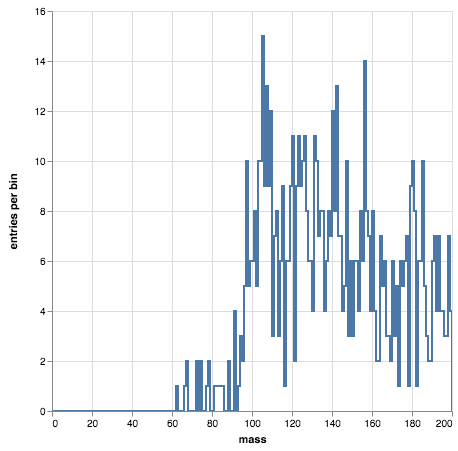

In [66]:
Hist(bin("mass", 200, 0, 200), fill=mass).step(width=400, height=400)   # .to(VegaLite)

![](src/visualization.png)

# Pandas: data analysis on indexed tables

Pandas is a library for manipulating tabular data, but as we've just seen, so is Numpy.

Pandas is based on Numpy. So what's its "value added?"

## Rich indexing!!!

Although the elements of a Numpy array can be accessed in fancy ways, each item is conceptually addressed by a single integer: the entry number. Indexes in Pandas can be typed (e.g. string keys like a `dict`), structured like the two-component index for jagged data below, and sparse (as below).

In [67]:
df = events.pandas.df(["MET*", "Muon*"])
df

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

MET_px     MET_py     Muon_Px    Muon_Py     Muon_Pz  \
entry subentry                                                            
0     0          5.912771   2.563633  -52.899456 -11.654672   -8.160793   
      1               NaN        NaN   37.737782   0.693474  -11.307582   
1     0         24.765203 -16.349110   -0.816459 -24.404259   20.199968   
2     0        -25.785088  16.237131   48.987831 -21.723139   11.168285   
      1               NaN        NaN    0.827567  29.800508   36.965191   
3     0          8.619896 -22.786547   22.088331 -85.835464  403.848450   
      1               NaN        NaN   76.691917 -13.956494  335.094208   
4     0          5.393139  -1.310052   45.171322  67.248787  -89.695732   
      1               NaN        NaN   39.750957  25.403667   20.115053   
5     0         -3.759475 -19.417021    9.228110  40.554379  -14.642164   
      1               NaN        NaN   -5.793715 -30.295189   42.954376   
6     0         23.962149  -9.049156   12.538717 -42.548710 -124.448990   
      1               NaN        NaN   29.541840  -4.445517  -26.356554   
7     0        -57.533348 -20.487679   34.883759 -15.982724  155.531174   
8     0         42.416195 -94.350861  -53.166973  92.029709   35.638836   
      1               NaN        NaN   11.491870  -4.417387  -17.473787   
9     0         -1.914469 -23.963034  -67.014854  53.159172   54.412941   
      1               NaN        NaN  -18.118755 -35.106167   58.036896   
10    0         19.710058   4.645509   15.983028  49.113922  118.148361   
      1               NaN        NaN   34.684406 -30.967381  193.678818   
11    0        -35.538055 -14.753822  -70.511909 -27.018003  -15.325147   
      1               NaN        NaN  -38.028744  33.250092  -70.318031   
12    0         15.209903  -6.397500   58.943813  53.778435   38.638081   
13    0         28.459160   5.657520  -15.587871 -21.090380   -2.229333   
14    0         -9.093978   0.861486 -122.330116  37.771309 -215.759995   
      1               NaN        NaN   -1.059753  49.608921  -69.047165   
15    0          0.350357  -4.255576  -46.704155 -28.666719    8.281767   
      1               NaN        NaN   39.020023  18.711084  -13.494764   
16    0         -0.201901  -3.499514   51.294659 -16.858574   47.350216   
      1               NaN        NaN   17.450920  25.667665  -29.315439   
...                   ...        ...         ...        ...         ...   
2399  0          4.515370  -4.102074   52.586819   5.415618  -12.101402   
      1               NaN        NaN  -19.218178  -1.992126   26.320738   
2400  0        -10.098569 -54.974846   57.859886  15.802021   49.297092   
      1               NaN        NaN    1.737445  56.352654  -13.958491   
2401  0          2.998099  21.993523   -1.492689 -35.336575  -52.167149   
2402  0         27.944883 -37.503429   -4.560287  39.478573   26.715488   
2403  0          3.787466 -21.217653   -9.715589 -29.786343  -71.578506   
2404  0          9.378232  27.572329  -31.072098 -55.729004  149.663727   
2405  0        -17.310106   5.082886   47.484627  22.261318  -13.176701   
      1               NaN        NaN    4.695312  35.813728   66.385490   
2406  0        -81.965927 -11.167821   74.756172 -14.697798 -113.745506   
      1               NaN        NaN  -20.911081  23.299616 -113.811455   
2407  0         -9.059591 -24.464552   25.786427  37.408089    7.364011   
      1               NaN        NaN  -29.265024  -0.183838   82.522552   
2408  0         25.649775  -2.818718         NaN        NaN         NaN   
2409  0         29.691553  56.606071  -24.736799  20.442957   34.178497   
2410  0        -25.754967  14.037041   53.005814 -24.486130   13.952395   
      1               NaN        NaN  -30.208649  19.269384   18.660769   
2411  0         -2.426847 -30.494087   55.720299  26.369698  -24.587757   
      1               NaN        NaN  -26.914448  -9.812821   -0.389948   
2412  0        -15.611773  -9.571323   14.89

In [72]:
df.loc[0,0]

MET_px          5.912771
MET_py          2.563633
Muon_Px       -52.899456
Muon_Py       -11.654672
Muon_Pz        -8.160793
Muon_E         54.779499
Muon_Charge     1.000000
Muon_Iso        4.200153
Name: (0, 0), dtype: float64

Indexes can be fluidly manipulated. For instance, convert this structured index into integer-indexed columns:

In [73]:
df.reset_index()

,entry,subentry,MET_px,MET_py,Muon_Px,Muon_Py,Muon_Pz,Muon_E,Muon_Charge,Muon_Iso
0,0,0,5.912771,2.563633,-52.899456,-11.654672,-8.160793,54.779499,1.0,4.200153
1,0,1,NaN,NaN,37.737782,0.693474,-11.307582,39.401695,-1.0,2.151061
2,1,0,24.765203,-16.349110,-0.816459,-24.404259,20.199968,31.690445,1.0,2.188047
3,2,0,-25.785088,16.237131,48.987831,-21.723139,11.168285,54.739788,1.0,1.412822
4,2,1,NaN,NaN,0.827567,29.800508,36.965191,47.488857,-1.0,3.383504
5,3,0,8.619896,-22.786547,22.088331,-85.835464,403.848450,413.460022,-1.0,2.728488
6,3,1,NaN,NaN,76.691917,-13.956494,335.094208,344.041534,1.0,0.552297
7,4,0,5.393139,-1.310052,45.171322,67.248787,-89.695732,120.864319,-1.0,0.000000
8,4,1,NaN,NaN,39.750957,25.403667,20.115053,51.284611,1.0,0.856398
9,5,0,-3.759475,-19.417021,9.228110,40.554379,-14.642164,44.093307,1.0,0.000000


Flatten the sparse subentries into dense columns: a column for each number of muons:

In [74]:
df2 = df.pivot_table(index="entry", columns="subentry")
df2

MET_px      MET_py Muon_Charge                    Muon_E  \
subentry           0           0           0    1    2   3           0   
entry                                                                    
0           5.912771    2.563633         1.0 -1.0  NaN NaN   54.779499   
1          24.765203  -16.349110         1.0  NaN  NaN NaN   31.690445   
2         -25.785088   16.237131         1.0 -1.0  NaN NaN   54.739788   
3           8.619896  -22.786547        -1.0  1.0  NaN NaN  413.460022   
4           5.393139   -1.310052        -1.0  1.0  NaN NaN  120.864319   
5          -3.759475  -19.417021         1.0 -1.0  NaN NaN   44.093307   
6          23.962149   -9.049156        -1.0 -1.0  NaN NaN  132.118027   
7         -57.533348  -20.487679         1.0  NaN  NaN NaN  160.194519   
8          42.416195  -94.350861        -1.0  1.0  NaN NaN  112.099648   
9          -1.914469  -23.963034         1.0 -1.0  NaN NaN  101.378830   
10         19.710058    4.645509         1.0 -1.0  NaN NaN  128.944489   
11        -35.538055  -14.753822        -1.0  1.0  NaN NaN   77.050461   
12         15.209903   -6.397500        -1.0  NaN  NaN NaN   88.653290   
13         28.459160    5.657520        -1.0  NaN  NaN NaN   26.320467   
14         -9.093978    0.861486        -1.0  1.0  NaN NaN  250.885864   
15          0.350357   -4.255576         1.0 -1.0  NaN NaN   55.422535   
16         -0.201901   -3.499514        -1.0  1.0  NaN NaN   71.815094   
17          8.286861   -3.266164        -1.0  NaN  NaN NaN  128.362946   
18         -7.835592  -13.773303        -1.0  1.0  NaN NaN   50.604622   
19        -41.880852 -157.988144        -1.0  1.0  1.0 NaN  108.971756   
20         -1.715726   19.486519        -1.0  1.0  NaN NaN   70.670784   
21          2.373739   -8.089888        -1.0  1.0  NaN NaN   41.347275   
22        -30.234993    2.027190         1.0 -1.0  NaN NaN  105.427437   
23         13.711685   -6.066514         1.0  NaN  NaN NaN   70.711792   
24        130.723969   74.998268        -1.0  NaN  NaN NaN  121.933960   
25         -6.254472   18.144054         1.0 -1.0  NaN NaN   97.748543   
26        -14.468836   16.849669        -1.0  NaN  NaN NaN   54.999378   
27         -1.018478   -8.156774         1.0  NaN  NaN NaN   74.270279   
28         12.017437    1.811257         1.0 -1.0  NaN NaN   88.608315   
29        -14.349060   14.992454         1.0 -1.0  NaN NaN  214.950195   
...              ...         ...         ...  ...  ...  ..         ...   
2391        5.421937  -40.910957        -1.0  NaN  NaN NaN   34.387745   
2392       10.979458    4.336320         1.0  NaN  NaN NaN   83.929939   
2393       34.796410   -2.099867         1.0 -1.0  NaN NaN  129.627914   
2394        0.745414  -54.461945        -1.0  1.0  NaN NaN   86.868126   
2395       19.757299  -44.224178        -1.0  NaN  NaN NaN   69.374352   
2396      104.612236  -98.111153         1.0 -1.0  NaN NaN  183.339615   
2397        3.185825   79.226997         1.0 -1.0  NaN NaN  354.532684   
2398        1.150845   -3.101060        -1.0  NaN  NaN NaN   32.210594   
2399        4.515370   -4.102074        -1.0  1.0  NaN NaN   54.232441   
2400      -10.098569  -54.974846        -1.0  1.0  NaN NaN   77.638168   
2401        2.998099   21.993523         1.0  NaN  NaN NaN   63.026375   
2402       27.944883  -37.503429        -1.0  NaN  NaN NaN   47.886139   
2403        3.787466  -21.217653         1.0  NaN  NaN NaN   78.135216   
2404        9.378232   27.572329        -1.0  NaN  NaN NaN  162.697388   
2405      -17.310106    5.082886        -1.0  1.0  NaN NaN   54.073956   
2406      -81.965927  -11.167821        -1.0  1.0  NaN NaN  136.903473   
2407       -9.059591  -24.464552         1.0 -1.0  NaN NaN   46.027653   
2408       25.649775   -2.818718         NaN  NaN  NaN NaN         NaN   
2409       29.691553   56.606071        -1.0  NaN  NaN NaN   46.882881   
2410      -25.754967   14.037041        -1.0  1.0  NaN NaN   60.032219   
2411       -2.4268

In [80]:
df2[b"Muon_E",1]

entry
0        39.401695
1              NaN
2        47.488857
3       344.041534
4        51.284611
5        52.881523
6        39.839203
7              NaN
8        21.375706
9        70.207016
10      199.182037
11       86.581703
12             NaN
13             NaN
14       85.027588
15       45.329758
16       42.693909
17             NaN
18       89.173965
19       37.092846
20       34.850731
21      141.920624
22       62.692585
23             NaN
24             NaN
25       36.540340
26             NaN
27             NaN
28       30.236483
29       59.021538
           ...    
2391           NaN
2392           NaN
2393     43.540268
2394     31.413742
2395           NaN
2396     58.579353
2397     42.558590
2398           NaN
2399     32.651176
2400     58.081760
2401           NaN
2402           NaN
2403           NaN
2404           NaN
2405     75.575882
2406    118.038986
2407     87.558311
2408           NaN
2409           NaN
2410     40.399345
2411     28.650345
2412  

Numpy concepts and functions apply to Pandas.

In [81]:
# make a mask of events with at least two muons (second muon index is not nan)
has2muons = numpy.logical_not(numpy.isnan(df2[b"Muon_E", 1]))
df3 = df2[has2muons]

# select particle attributes for the first and second muons through filter
e1,  e2  = df3[b"Muon_E",  0], df3[b"Muon_E",  1]
px1, px2 = df3[b"Muon_Px", 0], df3[b"Muon_Px", 1]
py1, py2 = df3[b"Muon_Py", 0], df3[b"Muon_Py", 1]
pz1, pz2 = df3[b"Muon_Pz", 0], df3[b"Muon_Pz", 1]

# vectorized calculation like Numpy
mass = numpy.sqrt((e1 + e2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
mass

entry
0        90.227806
2        74.746544
3        89.757660
4        94.855217
5        92.116730
6        53.364296
8        89.849709
9        96.036957
10       86.800598
11       87.297325
14       94.140106
15       99.828293
16       89.350464
18       93.016579
19       87.974571
20       94.411560
21       93.166130
22       89.052620
25       95.242233
28       91.135353
29      131.628998
30       84.158096
32      121.707344
34       29.481588
38       85.689392
39       94.390388
40       92.176292
41       90.833351
45       84.978996
47       73.103790
           ...    
2363     88.814896
2364     92.167427
2365     94.188080
2366     88.083389
2368     89.303658
2370     89.612633
2371     92.044205
2372     91.849739
2374     91.372322
2375     89.863190
2379     37.465485
2380     91.591888
2381     92.285912
2382     89.810768
2384     82.759064
2386     84.660004
2387     90.170708
2389     90.993820
2393     86.904953
2394     88.478378
2396     94.030556
2397  

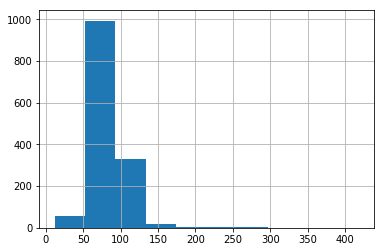

In [82]:
%matplotlib inline
mass.hist()

# Faster math: NumExpr, Numba, and Cython

The Python development strategy is to write slow Python until it gets to be a problem and then accelerate the problem spots.

In [83]:
# some require actual Numpy arrays, not Pandas series
e1, e2, px1, px2, py1, py2, pz1, pz2 = (
    numpy.array(e1), numpy.array(e2), numpy.array(px1), numpy.array(px2),
    numpy.array(py1), numpy.array(py2), numpy.array(pz1), numpy.array(pz2))

## NumExpr

Mini-compiler to process Numpy arrays in one pass, rather than one per column.

In [85]:
import numexpr
numexpr.evaluate("sqrt((e1 + e2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)")

array([90.227806, 74.746544, 89.75766 , ..., 92.06495 , 85.44384 ,
       75.96062 ], dtype=float32)

## Numba

More general: uses LLVM to just-in-time compile Python code to native bytecode.

In [ ]:
#!pip install numba --user

In [86]:
import numba

@numba.jit
def f(e1, e2, px1, px2, py1, py2, pz1, pz2):
    out = numpy.empty(len(e1))
    for i in range(len(e1)):
        out[i] = math.sqrt((e1[i] + e2[i])**2 - (px1[i] + px2[i])**2 - (py1[i] + py2[i])**2 - (pz1[i] + pz2[i])**2)
    return out

f(e1, e2, px1, px2, py1, py2, pz1, pz2)

/usr/local/lib/python2.7/dist-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/usr/local/lib/python2.7/dist-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *


array([90.22780609, 74.74654388, 89.75765991, ..., 92.06494904,
       85.44384003, 75.96061707])

## Cython

Cython is a half-way language between C++ and Python for static compilation and C++ bindings.

In [87]:
%load_ext Cython

*(continued next page)*

In [88]:
%%cython -a --cplus -c-std=c++11 -c-O3

import numpy

cdef extern from *:
    """
    void doit(int N, float* out, float* e1, float* e2, float* px1, float* px2,
                                 float* py1, float* py2, float* pz1, float* pz2) {
        for (int i = 0;  i < N;  i++) {
            out[i] = sqrt((e1[i] + e2[i])*(e1[i] + e2[i]) - (px1[i] + px2[i])*(px1[i] + px2[i]) -
                          (py1[i] + py2[i])*(py1[i] + py2[i]) - (pz1[i] + pz2[i])*(pz1[i] + pz2[i]));
        }
    }
    """
    void doit(int N, float* out, float* e1, float* e2, float* px1, float* px2, float* py1, float* py2, float* pz1, float* pz2)

def g(e1, e2, px1, px2, py1, py2, pz1, pz2):
    if (not isinstance(e1, numpy.ndarray) or not isinstance(e2, numpy.ndarray) or
        not isinstance(px1, numpy.ndarray) or not isinstance(px2, numpy.ndarray) or
        not isinstance(py1, numpy.ndarray) or not isinstance(py2, numpy.ndarray) or
        not isinstance(pz1, numpy.ndarray) or not isinstance(pz2, numpy.ndarray)):
        raise TypeError("these are not arrays")

    out = numpy.empty(len(e1), dtype=numpy.float32)    
    doit(len(e1), <float*>(<size_t>out.ctypes.data),
         <float*>(<size_t>e1.ctypes.data), <float*>(<size_t>e2.ctypes.data),
         <float*>(<size_t>px1.ctypes.data), <float*>(<size_t>px2.ctypes.data),
         <float*>(<size_t>py1.ctypes.data), <float*>(<size_t>py2.ctypes.data),
         <float*>(<size_t>pz1.ctypes.data), <float*>(<size_t>pz2.ctypes.data))
    return out

In [89]:
g(e1, e2, px1, px2, py1, py2, pz1, pz2)

array([90.227806, 74.746544, 89.75766 , ..., 92.06495 , 85.44384 ,
       75.96062 ], dtype=float32)

# Dask: delayed and distributed computing

In [ ]:
#!pip install "dask[complete]" --user

In [90]:
lazyarrays = uproot.daskarrays("http://scikit-hep.org/uproot/examples/HZZ.root", "events")

In [91]:
lazyarrays

{'Electron_Charge': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Electron_E': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Electron_Iso': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Electron_Px': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Electron_Py': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Electron_Pz': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'EventWeight': dask.array<array, shape=(2421,), dtype=float32, chunksize=(2421,)>,
 'Jet_E': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Jet_ID': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Jet_Px': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Jet_Py': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Jet_Pz': dask.array<array, shape=(2421,), dtype=object, chunksize=(2421,)>,
 'Jet_btag': dask.array<a

In [92]:
pt = numpy.sqrt(lazyarrays[b"MET_px"]**2 + lazyarrays[b"MET_py"]**2)
pt

dask.array<sqrt, shape=(2421,), dtype=float32, chunksize=(2421,)>

`pt` is an *instruction* for a calculation that can be distributed across a cluster. (We don't have a cluster.)

In [93]:
pt.compute()

array([ 6.4446163, 29.675053 , 30.471546 , ..., 53.449284 , 95.502464 ,
       20.038935 ], dtype=float32)

# NumPythia, PyJet, and PyPDT: for quick generator-level studies

## NumPythia

In [ ]:
#!pip install numpythia --user      # it takes a long time to compile Pythia...

In [94]:
import numpythia
import numpythia.testcmnd
pythia = numpythia.Pythia(numpythia.testcmnd.get_cmnd("w"), random_state=1)

In [95]:
import pandas
events = list(pythia(events=1))    # pythia is a generator; evaluate it
pandas.DataFrame(events[0].all())  # event.all(SELECTION) returns a Numpy record array, so of course we Pandas it

,E,px,py,pz,mass,prodx,prody,prodz,prodt,pdgid,status
0,6500.000000,0.000000e+00,0.000000e+00,6499.999932,9.382700e-01,0.000000,0.000000,0.000000,0.000000,2212,4
1,156.337354,-1.603964e+00,1.789967e+00,156.318878,1.388571e-05,0.000000,0.000000,0.000000,0.000000,21,61
2,3157.193528,1.632030e-01,-1.049595e+00,3157.193255,7.713300e-01,0.000000,0.000000,0.000000,0.000000,2203,63
3,3186.477199,1.440761e+00,-7.403724e-01,3186.476770,3.300000e-01,0.000000,0.000000,0.000000,0.000000,1,63
4,156.328011,0.000000e+00,2.220446e-16,156.328011,1.452593e-05,0.000000,0.000000,0.000000,0.000000,21,53
5,3157.193528,1.632030e-01,-1.049595e+00,3157.193255,7.713300e-01,0.000000,0.000000,0.000000,0.000000,2203,71
6,3186.477199,1.440761e+00,-7.403724e-01,3186.476770,3.300000e-01,0.000000,0.000000,0.000000,0.000000,1,71
7,151.160792,0.000000e+00,1.110223e-16,151.160792,1.027139e-05,0.000000,0.000000,0.000000,0.000000,21,41
8,132.235959,3.330669e-14,-7.549517e-14,132.235959,-5.394797e-06,0.000000,0.000000,0.000000,0.000000,21,53
9,18.966263,-1.438213e+00,1.221482e+00,18.872166,1.450244e-06,0.000000,0.000000,0.000000,0.000000,21,43


## pyjet

In [ ]:
!pip install pyjet --user

In [96]:
import pyjet

fourvectors = events[0].all()[["E", "px", "py", "pz"]]
for jet in pyjet.cluster(fourvectors, R=1.0, p=-1, ep=True).inclusive_jets():
    print(jet)

PseudoJet(pt=2909.400, eta=-0.778, phi=0.947, mass=1292.519)
PseudoJet(pt=2572.100, eta=-1.973, phi=-2.263, mass=1587.844)
PseudoJet(pt=201.637, eta=1.507, phi=-1.185, mass=58.241)
PseudoJet(pt=49.311, eta=-3.790, phi=2.058, mass=29.501)
PseudoJet(pt=26.513, eta=-4.338, phi=-2.149, mass=89.196)
PseudoJet(pt=16.728, eta=3.088, phi=2.557, mass=11.668)
PseudoJet(pt=14.165, eta=-0.257, phi=-1.441, mass=13.213)
PseudoJet(pt=9.817, eta=0.009, phi=1.695, mass=3.142)
PseudoJet(pt=9.261, eta=-8.374, phi=-2.268, mass=7.053)
PseudoJet(pt=8.531, eta=8.208, phi=-0.457, mass=6.606)
PseudoJet(pt=6.348, eta=-2.649, phi=0.028, mass=2.832)
PseudoJet(pt=3.513, eta=0.227, phi=-3.114, mass=2.351)
PseudoJet(pt=2.876, eta=5.235, phi=2.406, mass=1.891)
PseudoJet(pt=2.590, eta=2.299, phi=0.261, mass=1.236)
PseudoJet(pt=2.579, eta=8.581, phi=-1.500, mass=2.023)
PseudoJet(pt=2.478, eta=-6.952, phi=0.853, mass=-0.000)
PseudoJet(pt=2.208, eta=5.565, phi=-0.178, mass=3.658)
PseudoJet(pt=2.068, eta=-2.560, phi=2.793

## PyPDT

In [ ]:
!pip install pypdt --user

In [97]:
import pypdt

for pdgid in set(events[0].all()["pdgid"]):
    p = pypdt.get(pdgid)
    if p is not None:
        print("{}: {} mass: {} width {} lifetime {} ctau {}".format(
            pdgid, p.name, p.mass, p.width, p.lifetime, p.ctau))

1: dbar mass: 0.0047 width None lifetime None ctau None
2: ubar mass: 0.0022 width None lifetime None ctau None
3: sbar mass: 0.096 width None lifetime None ctau None
22: gamma0 mass: 0.0 width 0.0 lifetime None ctau None
11: e- mass: 0.0005109989461 width 0.0 lifetime None ctau None
130: K(L)0 mass: 0.497611 width 1.287e-17 lifetime 51143.1090909 ctau 15332.3183841
14: nu_mu mass: 0.0 width 0.0 lifetime None ctau None
21: g0 mass: 0.0 width 0.0 lifetime None ctau None
3222: Sigma+ mass: 1.18937 width 8.209e-15 lifetime 80.1817290778 ctau 24.0378776469
23: Z0 mass: 91.1876 width 2.4952 lifetime 2.63791204713e-13 ctau 7.90826136597e-14
2212: p+ mass: 0.938272081 width 0.0 lifetime None ctau None
3112: Sigma- mass: 1.197449 width 4.45e-15 lifetime 147.912767191 ctau 44.3431320458
-213: rho(770)- mass: 0.77526 width 0.1491 lifetime 4.41456615694e-12 ctau 1.32345363919e-12
-211: pi- mass: 0.13957018 width 2.5284e-17 lifetime 26032.7406265 ctau 7804.41930089
2224: Delta(1232)++ mass: 1.232 

# The End!